In [1]:
import matplotlib.pyplot as pl
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib.patches import Circle
%matplotlib inline

## Analysis of the cube

Let's start by lazyly opening the file with `astropy.io.fits`

In [29]:
f = fits.open('sky_ldev.fits')
f_cont = fits.open('cont_ldev.fits')

The header contains relevant information about the file: how to reconstruct the axis, number of elements of the cube, etc.

In [3]:
print(f[0].header)

SIMPLE  =                    T  /                                               BITPIX  =                  -32  /                                               NAXIS   =                    3  /                                               NAXIS1  =                 1286  /                                               NAXIS2  =                 1286  /                                               NAXIS3  =                 6668  /                                               EXTEND  =                    T  /                                               BSCALE  =    1.00000000000E+00  /                                               BZERO   =    0.00000000000E+00  /                                               BLANK   =                   -1  /                                               BUNIT   = 'Jy/beam '  /                                                         CRPIX1  =    6.43000000000E+02  /                                               CDELT1  =   -7.77777777778E-04  /       

In [43]:
print(f_cont[0].header)

SIMPLE  =                    T  /                                               BITPIX  =                  -32  /                                               NAXIS   =                    3  /                                               NAXIS1  =                 1286  /                                               NAXIS2  =                 1286  /                                               NAXIS3  =                   21  /                                               EXTEND  =                    T  /                                               BSCALE  =    1.00000000000E+00  /                                               BZERO   =    0.00000000000E+00  /                                               BLANK   =                   -1  /                                               BUNIT   = 'JY/BEAM '  /                                                         CRPIX1  =    6.43000000000E+02  /                                               CDELT1  =   -7.77777777778E-04  /       

The cube is of size

In [44]:
print(f[0].data.shape)
print(f_cont[0].data.shape)

(6668, 1286, 1286)
(21, 1286, 1286)


where the first element refers to the frequency axis and the remaining two refer to the spatial coordinates given in right ascension and declination.

## Coordinates
Instead of reconstructing the coordinates by hand, let us use the World Coordinate System methods of `astropy`. Let us generate the wcs object that will be used to reconstruct all coordinates.

In [45]:
wcs=WCS(f[0].header)
wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  
CRVAL : 180.0  -30.0  950000000.0  
CRPIX : 643.0  643.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.000777777777778  0.000777777777778  30000.0  
NAXIS : 1286  1286  6668

As an example, we can compute the coordinates of the pixel (20,20,20), which is given in `SkyCoord` coordinates.

In [46]:
coord = wcs.pixel_to_world(20, 20, 20)
coord

[<SkyCoord (ICRS): (ra, dec) in deg
     (180.56137725, -30.48259848)>,
 <Quantity 9.506e+08 Hz>]

Let's try to go back from physical units to pixel units by defining the coordinates by hand. We make use of the `units` package of `astropy`:

In [47]:
ra = 180.56137725 * u.deg
dec = -30.48259848 * u.deg
coords = SkyCoord(ra, dec, unit="deg")
freq = 9.506e+08 * u.Hz
wcs.world_to_pixel(coords, freq)

(array(19.99999691), array(19.99999401), array(20.))

We can then easily generate the coordinates for each axis, which might be interesting for later:

In [9]:
nx, ny, nf = wcs.pixel_shape
x = np.zeros(nx)
for i in range(nx):
    tmp = wcs.pixel_to_world(i, 0, 0)
    x[i] = tmp[0].ra.value
    
y = np.zeros(ny)
for i in range(ny):
    tmp = wcs.pixel_to_world(0, i, 0)
    y[i] = tmp[0].dec.value
    
freq = np.zeros(nf)
for i in range(nf):
    tmp = wcs.pixel_to_world(0, 0, i)
    freq[i] = tmp[1].value

## Catalog
Let's analyze the cube and see if we can detect by eye the source with the largest integrated flux in the line. The first thing is to read the catalog. One can use `pandas` for this but we use a simpler method reading it using `numpy.loadtxt`:

In [8]:
cat = np.loadtxt('sky_ldev_truthcat.txt', skiprows=1)[:, 1:]
print(cat.shape)

(11112, 8)


We check that we've read it properly by also showing some histograms:

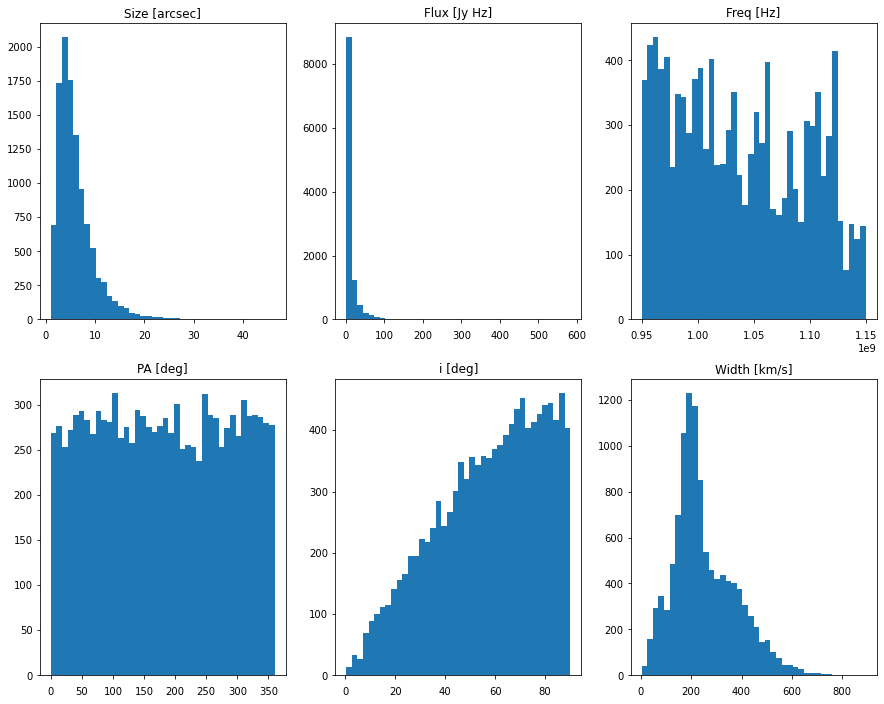

In [9]:
labels = ['Size [arcsec]', 'Flux [Jy Hz]', 'Freq [Hz]', 'PA [deg]', 'i [deg]', 'Width [km/s]']
fig, ax = pl.subplots(nrows=2, ncols=3, figsize=(15,12))
for i in range(6):
    ax.flat[i].hist(cat[:,2+i], bins=40)
    ax.flat[i].set_title(labels[i])

Now we sort the sources by the integrated flux. The flux is given in the fourth column because we got rid of the index:

In [10]:
ind_sort = np.argsort(cat[:,3])
ind_peak = ind_sort[-1]
print(ind_peak)
print(cat[ind_peak, :])

841
[ 1.79799332e+02 -3.04431763e+01  1.87992370e+01  5.82329078e+02
  1.12422605e+09  1.76621185e+02  5.26458092e+01  3.61810514e+02]


It is located at line 841 in the catalog. Now we can use the values of ra, dec and frequency from the catalog to find the pixel coordinates in the cube:

In [72]:
ind = ind_sort[-12]
ra = cat[ind, 0] * u.deg
dec = cat[ind, 1] * u.deg
coords = SkyCoord(ra, dec, unit="deg")
freq = cat[ind, 4] * u.Hz
coords = wcs.world_to_pixel(coords, freq)
print(coords)

(array(1261.61069889), array(758.19033335), array(6182.77973333))


It is located roughly at frequency 5807, so that we can show this slice from the cube and show some lines indicating the ra and dec positions. We check that the source is there so everything makes sense.

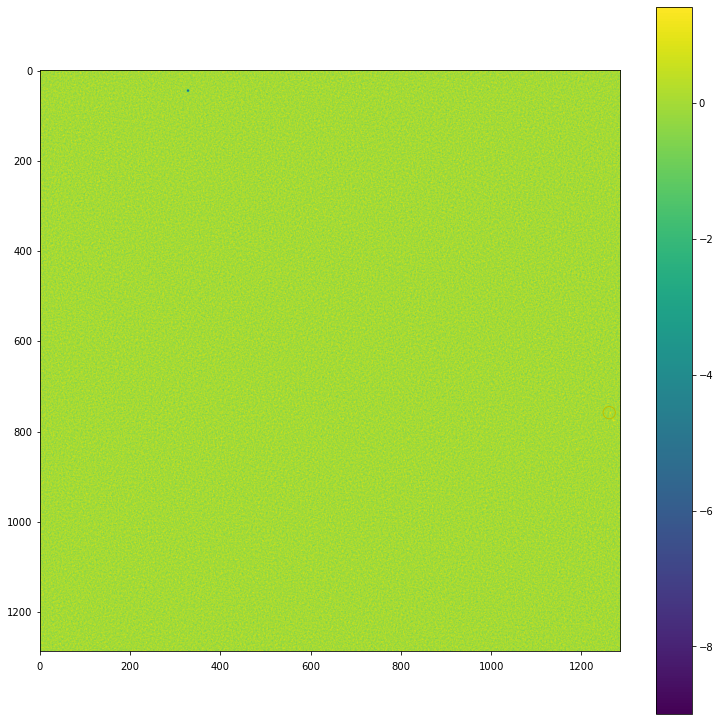

In [73]:
fig, ax = pl.subplots(figsize=(13,13))
map = ax.imshow((f[0].data[int(coords[2]), :, :] / 1e-4))
pl.colorbar(map, ax=ax)
ax.scatter(coords[0], coords[1], s=150, facecolors='none', edgecolors='y')

Text(0.5, 1.0, 'Continuum')

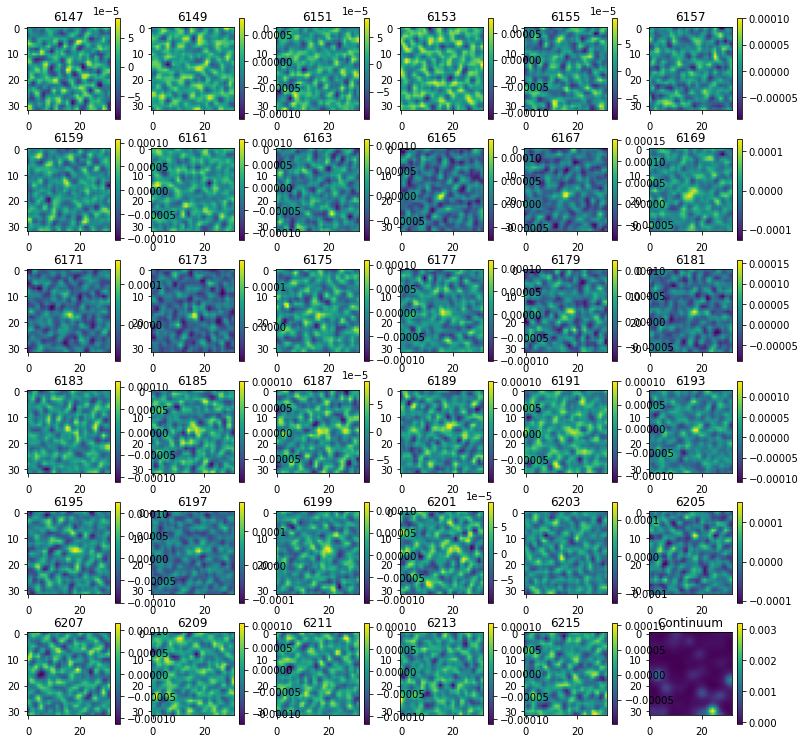

In [74]:
fig, ax = pl.subplots(nrows=6, ncols=6, figsize=(13,13))
step = 2
npanels = np.prod(ax.shape) - 1
init = int(coords[2] - step * npanels/2)
lowy = int(coords[1]) - 16
lowx = int(coords[0]) - 16
for i in range(35):
    map = ax.flat[i].imshow(f[0].data[init+step*i, lowy:lowy+32, lowx:lowx+32])    
    pl.colorbar(map, ax=ax.flat[i])
    ax.flat[i].set_title(f'{init+step*i}')
map = ax.flat[-1].imshow(np.sum(f_cont[0].data[:, lowy:lowy+32, lowx:lowx+32], axis=0))
pl.colorbar(map, ax=ax.flat[-1])
ax.flat[-1].set_title(f'Continuum')

## Estimating size of training sets
Let's try to estimate the size of the training sets.

The maximum size of the sources is roughly 40 arcsec. Given the sampling of 2.7 arcsec/pixel, this makes a maximum size of:

In [50]:
40/2.7

14.814814814814813

Therefore, we potentially need images of size 15x15 centered on each source to have the full source on the image. In order to allow for non-perfect detection of ra and dec, let us say we fix images of size 32x32. Now, let's focus on the size in the spectral direction. The largest line width at 20% peak is roughly 800 km/s. A priori we don't know at which frequencies this happens. The line broadening in frequency units is given by:

$$
\Delta \nu = \nu \frac{v}{c}
$$

Using the largest width in velocity units and the largest frequency as upper limits, we find that the potentially largest line width in frequency units is:

In [51]:
delta_nu = np.max(cat[:, 4]) * np.max(cat[:, 7]) / 3e5
print(f'The largest frequency width is {delta_nu/1e6} MHz')

The largest frequency width is 3.417793223404876 MHz


Since the sampling in frequency units is 30 kHz, the number of pixels in the spectral direction is:

In [52]:
print(f'The largest frequency width in pixel units is {delta_nu*1e-3/30.}')

The largest frequency width in pixel units is 113.92644078016254


Building a dataset for these sources then requires:

In [53]:
print(f"{32*32*128*cat.shape[0]*32/8/1024/1024/1024} GB")

5.42578125 GB
